In [1]:
import sys
sys.path.append('/home/pb064/Ranglage/Code/relation_extration/')

In [55]:
import torch
import pandas as pd
from pytorch_pretrained_bert import BertAdam
from torch.nn import BCELoss
from numpy import mean
import numpy as np
import torchmetrics

train_batch_size=4
gradient_accumulation_steps=64
num_train_epochs=500

def get_data(count,batch_size,data,dev):
    data=data.iloc[count*batch_size:(count+1)*batch_size]
    x=data['para'].values
    y=list(data['ppt_vec'].values)
    y=torch.tensor(y).to(dev)
    return x, y

def gen_data(batch_size, data, dev):
    count=0
    while count*batch_size<len(data):
        yield get_data(count,batch_size,data,dev)
        count+=1

In [3]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=torch.load('/home/pb064/Ranglage/Models/FinBERT_L-12_H-768_A-12_pytorch/small_fine_tuning_classify_490.pt',map_location=dev)
test_data=pd.read_pickle('/home/pb064/Documents/generated_text/test.pkl')
_=model.eval()

In [33]:
gen = gen_data(train_batch_size, test_data, dev)

In [34]:
x,y=next(gen)

In [35]:
x

array(['四、公司重要公告 【梦百合】5月6日，梦百合发布“百合转债”开始转股的公告。公司于2018年11月8日公开发行可转换公司债券510万张，每张面值100元，发行总额51000万元，期限6年。根据有关规定和公司《公开发行可转换公司债券募集说明书》的约定，公司本次发行的“百合转债”自2019年5月14日起可转换为本公司股份',
       '预计社融增速全年大部分时间在 10-11%之间窄幅震荡运行，后续对市场走势的扰动也将逐渐减弱，可以更多关注结构。下一阶段，影响市场估值的核心金融数据转向 M1，预计 M1 同比增速底部已现，全年将震荡回升至7%-9%，对应全年来看股市表现大致为高波动和中枢回升',
       '有线电视仍然中国影响力最大的媒体形式之一，是“主流舆论”和“主流价值”传向千家万户的主渠道和主阵地。截至 2018 年末，有线电视总用户数 2.23 亿户，按一户 2.5 人测算，覆盖 5.58 亿人；但 2016 年以来用户数量不断减少。但随着网络和数字技术的快速发展，新媒体、新业态、新商业模式不断涌现，有线电视网络业务创新、转型升级受到分散运营、分割发展的制约，资源优势、规模效益得不到充分发挥，可持续发展面临重大挑战，亟须通过自上而下的引导推动改革',
       '2.根据捷昌驱动招股说明书的披露，升降办公桌在国内市场的渗透率约2%，我们假设未来几年渗透率有小幅上升（每年保持0.5%的增幅），则2021年办公领域升降桌的渗透率有望达到4%'],
      dtype=object)

In [36]:
y

tensor([[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]], device='cuda:0')

In [20]:
res=model(x)

In [21]:
y=y.type_as(res)

In [22]:
res

tensor([[1.2978e-05, 7.7888e-06, 7.4233e-06, 9.9999e-01],
        [1.1686e-05, 7.9040e-06, 7.2477e-06, 9.9999e-01],
        [9.9997e-01, 2.1321e-06, 1.3977e-05, 2.9430e-05],
        [9.9998e-01, 2.2441e-06, 2.9488e-05, 2.3851e-05]], device='cuda:0',
       grad_fn=<SigmoidBackward>)

In [23]:
y

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], device='cuda:0')

In [16]:
total_x=res

In [18]:
total_y=y

In [24]:
total_x=torch.stack([total_x,res])

In [25]:
total_x

tensor([[[1.0168e-05, 1.1652e-05, 1.1820e-05, 9.9998e-01],
         [9.9997e-01, 1.9681e-06, 1.5233e-05, 3.2575e-05],
         [9.1648e-06, 1.0832e-05, 1.0522e-05, 9.9998e-01],
         [9.9997e-01, 1.9357e-06, 2.2742e-05, 2.6075e-05]],

        [[1.2978e-05, 7.7888e-06, 7.4233e-06, 9.9999e-01],
         [1.1686e-05, 7.9040e-06, 7.2477e-06, 9.9999e-01],
         [9.9997e-01, 2.1321e-06, 1.3977e-05, 2.9430e-05],
         [9.9998e-01, 2.2441e-06, 2.9488e-05, 2.3851e-05]]], device='cuda:0',
       grad_fn=<StackBackward>)

In [26]:
total_y=torch.stack([total_y,y])

In [34]:
total_y.view(-1,4)

tensor([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]], device='cuda:0')

In [40]:
test_data.iloc[:20000].length.mean()

147.66475

In [37]:
%%time
with torch.no_grad():
    gen = gen_data(train_batch_size, test_data, dev)
    total_x=[]
    total_y=[]
    paras=[]
    for _ in range(5000):
        x,y = next(gen)
        paras.append(x)
        res = model(x)
        # y = y.type_as(res)
        total_x.append(res)
        total_y.append(y)

CPU times: user 5min 31s, sys: 144 ms, total: 5min 31s
Wall time: 5min 32s


In [32]:
torch_x.shape

torch.Size([5000, 4, 4])

In [5]:
torch_x=torch.stack(total_x)

In [6]:
torch_y=torch.stack(total_y)

In [44]:
torch_x_pred=(torch_x>=0.5).int()

In [48]:
torch_y

tensor([[[0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [1, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1]],

        ...,

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 1, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1]]], device='cuda:0')

In [49]:
torch_x_pred

tensor([[[0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 1, 0, 0],
         [1, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [1, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 0, 0, 1]],

        ...,

        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 0, 1, 0]],

        [[0, 0, 0, 1],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0]]], device='cuda:0', dtype=torch.int32)

In [46]:
torch_x_pred!=torch_y

tensor([[[False, False, False, False],
         [False, False, False, False],
         [False,  True, False,  True],
         [False, False, False, False]],

        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        ...,

        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [ True, False, False,  True],
         [False, False, False, False],
         [ True, False, False,  True]]], device='cuda:0')

In [53]:
torch.where(torch_x_pred!=torch_y)

(tensor([   0,    0,    3,  ..., 4999, 4999, 4999], device='cuda:0'),
 tensor([2, 2, 3,  ..., 1, 3, 3], device='cuda:0'),
 tensor([1, 3, 0,  ..., 3, 0, 3], device='cuda:0'))

In [57]:
paras=np.array(paras)

In [58]:
all_false=torch.where(torch_x_pred!=torch_y).cpu().numpy()

AttributeError: 'tuple' object has no attribute 'cpu'

In [85]:
txcp=torch_x_pred.cpu().numpy()
tyc=torch_y.cpu().numpy()
txc=torch_x.cpu().numpy()

In [86]:
txc

array([[[3.29673312e-05, 4.50658627e-05, 4.92332583e-05, 9.99964833e-01],
        [9.99963284e-01, 5.19100213e-05, 5.15051906e-05, 4.19930366e-05],
        [8.04968004e-05, 9.99929070e-01, 6.39258142e-05, 9.58233140e-05],
        [9.99963760e-01, 6.64397739e-05, 3.71151036e-05, 4.54697074e-05]],

       [[5.12392289e-05, 3.97978620e-05, 3.30468683e-05, 9.99956846e-01],
        [3.43115244e-05, 4.76015011e-05, 3.94087110e-05, 9.99961138e-01],
        [9.99961019e-01, 5.21149195e-05, 4.12510890e-05, 5.00871392e-05],
        [9.99971509e-01, 6.62564198e-05, 6.21899453e-05, 3.59946825e-05]],

       [[4.45248006e-05, 3.67818138e-05, 4.24964019e-05, 9.99960780e-01],
        [3.35946461e-05, 4.30121618e-05, 4.90795064e-05, 9.99965429e-01],
        [9.99970436e-01, 6.64892141e-05, 5.50895347e-05, 3.70237940e-05],
        [3.27469279e-05, 4.65735611e-05, 4.61854470e-05, 9.99965906e-01]],

       ...,

       [[9.99968648e-01, 6.50913862e-05, 4.83126896e-05, 4.02396727e-05],
        [9.99962568

In [87]:
txc[0][2]

array([8.0496800e-05, 9.9992907e-01, 6.3925814e-05, 9.5823314e-05],
      dtype=float32)

In [88]:
wu[0]

array([0, 2])

In [65]:
w=np.stack(np.where(txc!=tyc)).T

In [72]:
w=w[:,:2]

In [73]:
len(paras)

5000

In [74]:
len(torch_y)

5000

In [76]:
w[w[:,0]==0]

array([[0, 2],
       [0, 2]])

In [81]:
wu=np.unique(w,axis=0)

In [83]:
len(wu)

1175

In [98]:
dict_paras=[]
dict_y_true=[]
dict_y_pred=[]
dict_y_pred_int=[]
for i in wu:
    dict_paras.append(paras[i[0]][i[1]])
    dict_y_pred_int.append(txcp[i[0]][i[1]])
    dict_y_true.append(tyc[i[0]][i[1]])
    dict_y_pred.append(txc[i[0]][i[1]])
    
error_para={'paras':dict_paras,'y_pred':dict_y_pred,'y_pred_int':dict_y_pred_int,'y_true':dict_y_true}
df=pd.DataFrame(error_para)

In [100]:
pd.set_option("display.max_colwidth",None)
pd.set_option('display.max_rows',None)

In [101]:
df

paras  \
0                                                                                                                                                                                                                                                                           有线电视仍然中国影响力最大的媒体形式之一，是“主流舆论”和“主流价值”传向千家万户的主渠道和主阵地。截至 2018 年末，有线电视总用户数 2.23 亿户，按一户 2.5 人测算，覆盖 5.58 亿人；但 2016 年以来用户数量不断减少。但随着网络和数字技术的快速发展，新媒体、新业态、新商业模式不断涌现，有线电视网络业务创新、转型升级受到分散运营、分割发展的制约，资源优势、规模效益得不到充分发挥，可持续发展面临重大挑战，亟须通过自上而下的引导推动改革   
1                                                                                                                                                                                                                                                                                                                                                                                对标Palantir前景明确，公安大数据迎兑现窗口  [Table_Summary] 公司近日发布公告及公众号新闻，推出乾坤大数据操作系统等系列产品。公安及智慧城市大数据业务对标海外巨头Palantir，空间广阔并迎来兑现，电子取证格局稳固，维持买入评级   
2                                                                                                                                                                                                                                                                  股市情绪高涨预计股票融资将有所增长，季末贷款核销规模较大料将对社融构成一定的支撑。一方面，《政府工作报告》中强调要疏通货币政策传导路径，促进多层次资本市场建立并提高直接融资比例；另一方面，近日汇率、股市情绪齐涨，故我们预测3月股票融资将有所增长。依据近几年均值测算，预估存款类金融机构资产支持证券3月增量约为275.6 亿。一般来说，季末月贷款核销规模较大，并对社融形成一定的支撑。我们预计 3月股票融资、存款类金融机构资产支持证券及贷款核销三项新增规模约为1867.10亿   
3                                                                                                                                                                                                                                                                                                                                                                                                          宏观经济指标影响范围较广，主要描述整体宏观经济环境的发展速度、货币的宽松程度、社会投资力度以及政策支持力度等。其中，期限利差是用 10 年期国债收益率减去 1 年期国债收益率，主要反映未来经济增长的预期   
4                                                                                                                                                                                              请参阅最后一页的重要声明   上市公司深度报告 收购河北威远：布局阿维菌素、草铵膦热点产品，丰富农药品类 2018 年 10 月，利民股份发布公告：公司与欣荣投资及同意的其它第三方，拟筹划采用现金的方式收购新奥股份持有的河北威远生物化工有限公司、河北威远动物药业有限公司和内蒙古新威远生物化工有限公司的100%股权的协议。标的资产组农药板块拥有阿维菌素等多种杀虫剂产品，同时在除草剂草铵膦技术方面拥有先进的连续气相合成技术；标的资产组兽药板块拥有泰妙菌素、伊维菌素、乙酰氨基阿维菌素等多种兽药产品，可以弥补本公司在兽药方面的空白。通过本次收购，利民进一步布局杀虫剂和除草剂明星产品，丰富了杀虫剂、除草剂产品类别   
5                                                                                                                                                                                                                                                                                                                                                                                                 整体来看，当期市场正处于动能切换中继，后续市场动能将逐渐由分母端转向分子端。在这过程之中，我们建议防范通胀风险，猪、水果等物价大幅上涨，CPI 同比将会一直处于高位，叠加中美贸易关税导致的输入性通胀隐忧，通胀风险仍然较大   
6                                                                                                                                                                                                                                                                                                                3）从成长性看，关注本土化妆品崛起。我国化妆品市场广阔，本土化妆品“品牌+研发+营销+渠道”齐发力，崛起加速，与国外品牌研发差距迅速减小，借助线上渠道降低营销门槛，助力本土品牌形象重塑，加速推进产品高端化，并依靠粉丝经济提升消费粘性。从发达国家经验看，化妆品“口红效应”明显，受宏观经济环境影响较小，我们推荐与国际品牌定位与渠道布局错位的珀莱雅；多品类延伸且具备较强品牌力的上海家化   
7                                                                                                                                                                                                                                                                                                                                      技术研发是公司发展的核心动力。公司始终将水处理技术进步和研发能力提升作为公司发展的重要战略，研发费用近三年持续增长至2018年的2080万元，占营业收入比重维持在5%以上，研发人员占比维持在10%以上；截至 2018 年底，公司及子公司在水处理化学品和工艺技术领域已拥有发明专利、新型实用专利超过40项，较好地支撑了公司业务市场

In [103]:
df.to_excel('/tmp/error_pred.xlsx')

In [7]:
from torchmetrics import ROC

In [8]:
from torchmetrics.functional import stat_scores

In [23]:
stat_scores(torch_x.view(-1,1),torch_y.view(-1,1))

tensor([19299,  1148, 58511,  1042, 20341], device='cuda:0')

In [102]:
torchmetrics.functional.precision_recall(torch_x.view(-1,1),torch_y.view(-1,1),threshold=0.2)

(tensor(0.9421, device='cuda:0'), tensor(0.9507, device='cuda:0'))

In [11]:
roc=ROC()

/home/pb064/.pyenv/versions/3.8.0/envs/my-env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [12]:
fpr, tpr, thresholds = roc(torch_x, torch_y)

/home/pb064/.pyenv/versions/3.8.0/envs/my-env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


In [13]:
fpr

tensor([0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')

In [14]:
tpr

tensor([0.0000e+00, 4.9162e-05, 9.8324e-05,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00], device='cuda:0')

In [15]:
thresholds

tensor([2.0000e+00, 9.9999e-01, 9.9999e-01,  ..., 1.5699e-06, 1.3350e-06,
        1.2143e-06], device='cuda:0')

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
fpr=fpr.cpu().numpy()

In [18]:
tpr=tpr.cpu().numpy()

In [19]:
thresholds=thresholds.cpu().numpy()

In [20]:
from sklearn.metrics import auc


In [21]:
roc_auc= auc(fpr, tpr)


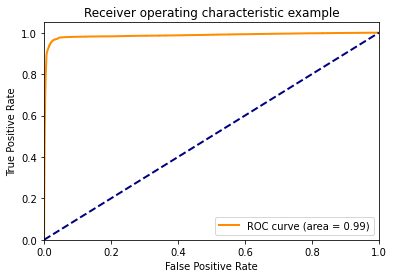

In [22]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()